## Изучение данных

In [2]:
import json
import pandas as pd
import numpy as np

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns

import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from catboost import CatBoostClassifier
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from scipy.stats import pointbiserialr, chi2_contingency
import shap

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
f = open('features_types.json')
features_types = json.load(f)

In [3]:
data_features = pd.DataFrame(features_types.items(), columns=['features', 'types'])
data_features.head()

,features,types
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric


Создадим отдельно таргет.

In [4]:
target=['target']

In [5]:
target = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=target)
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  702086 non-null  int32
dtypes: int32(1)
memory usage: 2.7 MB


In [6]:
target.value_counts()

target
0         696617
1           5469
dtype: int64

Выбираю только свою часть признаков.

In [7]:
my_data_features = data_features.iloc[930:1860]

In [8]:
my_data_features.types.value_counts()

numeric            851
categorical_int     69
categorical_str     10
Name: types, dtype: int64

In [9]:
my_data_features.head()

,features,types
930,vas_details_1_3_sum,numeric
931,vas_details_2_6_sum,numeric
932,vas_details_3_1_sum,numeric
933,vas_details_4_3_sum,numeric
934,vas_details_5_6_sum,numeric


Выделим списки числовых и категориальных фичей.

In [10]:
my_data_features_num = my_data_features[my_data_features['types'] == 'numeric']

In [11]:
my_data_features_cat = my_data_features[my_data_features['types'] != 'numeric']

In [12]:
my_data_features_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 851 entries, 930 to 1859
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   features  851 non-null    object
 1   types     851 non-null    object
dtypes: object(2)
memory usage: 19.9+ KB


## Обработка и удаление лишних признаков

In [4]:
# Функция для чтения данных
def read_data(left, right):

    # следующие т столбцов, которые будем считывать + target
    columns_to_read = my_data_features_num['features'][left:right].to_list() + ['target']

    # считываем столбцы в файл
    data = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=columns_to_read)

    return data

# Функция для отсеивания признаков с константными значениями
def variance_filter(data, threshold=0.5):

    # считаем дисперсию для каждого признака
    variance = data.var()

    # отбираем те фичи, у которых var > threshold
    selected_features = variance[variance > threshold].index.tolist()

    # собираем в датасет
    filtered_data = data[selected_features + ['target']]
    
    return filtered_data


# функция для проверки корреляции с таргетом
def corr_with_target(data):

    # чекаем корреляцию с таргетом
    correlation = data.corrwith(data['target']).abs()
    
    # сортируем
    correlation = correlation.sort_values(ascending=False)
    
    return correlation


# функция для удаления коррелирующих признаков
def remove_correlated_features(data, method='pearson', threshold=0.7):
    corr_matrix = data.corr(method=method).abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    data.drop(to_drop, axis=1, inplace=True)
    
    return data

# функция для даунсемплинга
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

# функция для апсемплинга
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# функция для выделения списка категориальных фичей
cat = ['ctg', 'flg','channel_name','src_id']
def cat_columns(columns, cat):
    cat_columns = []
    for col in columns:
        for c in cat:
            if c in col:
                cat_columns.append(col)
    return cat_columns

### Числовые признаки

Создадим датасет с числовыми признаками.

In [22]:
dataset_num = read_data(0, -1)
dataset_num.head()

,vas_details_1_3_sum,vas_details_2_6_sum,vas_details_3_1_sum,vas_details_4_3_sum,vas_details_5_6_sum,vas_details_6_1_sum,vas_details_7_3_sum,vas_details_8_6_sum,vas_details_9_1_sum,vas_details_10_3_sum,...,issues_47_6_sum,issues_48_1_sum,issues_49_3_sum,issues_50_6_sum,issues_51_1_sum,issues_52_3_sum,issues_53_6_sum,issues_54_1_sum,issues_55_3_sum,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [23]:
dataset_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 851 entries, vas_details_1_3_sum to target
dtypes: float64(850), int32(1)
memory usage: 4.4 GB


Удалим столбцы, где больше 2/3 пропусков.

In [24]:
dataset_num.dropna(thresh=len(dataset_num)/3, axis=1, inplace=True)

Фильтруем по дисперсии с помощью написанной ранее функции:

In [25]:
dataset_num = variance_filter(dataset_num)

In [26]:
dataset_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 616 entries, user_devices_3_1_cnt to target
dtypes: float64(615), int32(1)
memory usage: 3.2 GB


Посмотрим на корреляцию с таргетом, затем на корреляцию друг с другом. Удалим коррелирующие признаки.

In [27]:
corr_with_target(dataset_num)

target                          1.000000
spas_symptoms_agr_105_12_std    0.029562
spas_symptoms_agr_114_6_std     0.025710
spas_symptoms_ott_93_1_cnt      0.024054
spas_symptoms_ott_74_1_cnt      0.023913
                                  ...   
spas_symptoms_int_159_1_cnt     0.000049
spas_symptoms_int_60_1_cnt      0.000040
issues_22_3_sum                 0.000029
traffic_details_34_1d6_avg      0.000021
traffic_details_60_1_avg        0.000020
Length: 616, dtype: float64

In [28]:
dataset_num = remove_correlated_features(dataset_num)

In [29]:
dataset_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 191 entries, user_devices_3_1_cnt to target
dtypes: float64(190), int32(1)
memory usage: 1020.4 MB


### Категориальные признаки

Теперь посмотрим на категориальные:

In [48]:
columns_to_read = my_data_features_cat['features'].to_list()

dataset_cat = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=columns_to_read)

In [49]:
dataset_cat.head()

,communication_availability_4_1_flg,communication_availability_5_1_flg,communication_availability_6_1_flg,social_dem_0_0_flg,communication_availability_7_1_ctg,communication_availability_8_1_flg,communication_availability_9_1_flg,communication_availability_10_1_ctg,communication_availability_11_1_flg,communication_availability_12_1_flg,...,tariff_plans_17_src_id,deact_react_5_1_ctg,communication_availability_45_1_flg,user_active_4_1_flg,deact_react_7_1_ctg,exist_tariff_1_1_flg,tariff_plans_18_1_ctg,tariff_plans_19_src_id,deact_react_8_1_ctg,deact_react_10_1_ctg
0,1,1,1,-1,4,0,0,50,1,0,...,-1,0,1,1,0,0,4055,51551,-1,0
1,1,1,1,-1,4,0,0,50,1,0,...,-1,0,1,1,0,0,4055,51551,-1,0
2,1,1,1,-1,5,0,0,100,0,0,...,-1,0,1,1,0,0,3755,51529,-1,0
3,1,1,1,-1,4,0,0,100,0,0,...,-1,0,1,1,0,0,3637,51412,-1,0
4,1,1,1,-1,4,0,0,100,0,0,...,-1,0,1,1,0,0,2601,51675,-1,0


In [50]:
dataset_cat.describe()

,communication_availability_4_1_flg,communication_availability_5_1_flg,communication_availability_6_1_flg,social_dem_0_0_flg,communication_availability_7_1_ctg,communication_availability_8_1_flg,communication_availability_9_1_flg,communication_availability_10_1_ctg,communication_availability_11_1_flg,communication_availability_12_1_flg,...,tariff_plans_17_src_id,deact_react_5_1_ctg,communication_availability_45_1_flg,user_active_4_1_flg,deact_react_7_1_ctg,exist_tariff_1_1_flg,tariff_plans_18_1_ctg,tariff_plans_19_src_id,deact_react_8_1_ctg,deact_react_10_1_ctg
count,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,...,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000,702086.000000
mean,0.566758,0.501732,0.574743,-0.865487,3.980877,-0.038609,-0.050518,100.707492,0.175480,0.012487,...,28289.348044,0.039458,0.575189,0.983637,0.164100,0.098440,2923.678856,60700.114218,-0.955638,0.219420
std,0.605814,0.609479,0.604881,0.500932,1.463002,0.285249,0.261527,81.255250,0.515901,0.365784,...,33383.682066,0.459654,0.604825,0.179883,0.861815,0.337596,1201.665947,22220.519884,0.219681,1.087445
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000,4.000000,0.000000,0.000000,75.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1887.000000,45407.000000,-1.000000,0.000000
50%,1.000000,1.000000,1.000000,-1.000000,4.000000,0.000000,0.000000,100.000000,0.000000,0.000000,...,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2669.000000,55085.000000,-1.000000,0.000000
75%,1.000000,1.000000,1.000000,-1.000000,5.000000,0.000000,0.000000,100.000000,0.000000,0.000000,...,53628.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3872.000000,75261.000000,-1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,...,114540.000000,7.000000,1.000000,1.000000,6.000000,1.000000,5664.000000,115984.000000,1.000000,6.000000


Не жалея категориальные фичи, удалим категориальные признаки с большим разбросом:

In [51]:
to_drop_cat = []
for i in dataset_cat.columns.values:
    if dataset_cat[i].max()>10:
        to_drop_cat.append(i)

to_drop_cat

['communication_availability_10_1_ctg',
 'tariff_plans_12_1_ctg',
 'tariff_plans_13_src_id',
 'tariff_plans_14_1_ctg',
 'tariff_plans_15_src_id',
 'tariff_plans_16_1_ctg',
 'tariff_plans_17_src_id',
 'tariff_plans_18_1_ctg',
 'tariff_plans_19_src_id']

In [52]:
dataset_cat.drop(to_drop_cat, axis=1, inplace=True)

In [53]:
dataset_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 70 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   communication_availability_4_1_flg   702086 non-null  int32
 1   communication_availability_5_1_flg   702086 non-null  int32
 2   communication_availability_6_1_flg   702086 non-null  int32
 3   social_dem_0_0_flg                   702086 non-null  int32
 4   communication_availability_7_1_ctg   702086 non-null  int32
 5   communication_availability_8_1_flg   702086 non-null  int32
 6   communication_availability_9_1_flg   702086 non-null  int32
 7   communication_availability_11_1_flg  702086 non-null  int32
 8   communication_availability_12_1_flg  702086 non-null  int32
 9   communication_availability_13_1_flg  702086 non-null  int32
 10  communication_availability_14_1_flg  702086 non-null  int32
 11  communication_availability_15_1_flg  70

Удалим коррелирующие.

In [54]:
dataset_cat = remove_correlated_features(dataset_cat, 'spearman')

In [55]:
dataset_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 29 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   communication_availability_4_1_flg   702086 non-null  int32
 1   social_dem_0_0_flg                   702086 non-null  int32
 2   communication_availability_7_1_ctg   702086 non-null  int32
 3   communication_availability_8_1_flg   702086 non-null  int32
 4   communication_availability_11_1_flg  702086 non-null  int32
 5   communication_availability_12_1_flg  702086 non-null  int32
 6   communication_availability_17_1_flg  702086 non-null  int32
 7   communication_availability_18_1_flg  702086 non-null  int32
 8   communication_availability_19_1_flg  702086 non-null  int32
 9   communication_availability_28_1_flg  702086 non-null  int32
 10  user_active_0_1_flg                  702086 non-null  int32
 11  communication_availability_30_1_flg  70

In [78]:
dataset_cat = dataset_cat.astype('category')

Список категориальных фичей.

In [79]:
cat_cot = dataset_cat.columns.to_list()
cat_cot

['communication_availability_4_1_flg',
 'social_dem_0_0_flg',
 'communication_availability_7_1_ctg',
 'communication_availability_8_1_flg',
 'communication_availability_11_1_flg',
 'communication_availability_12_1_flg',
 'communication_availability_17_1_flg',
 'communication_availability_18_1_flg',
 'communication_availability_19_1_flg',
 'communication_availability_28_1_flg',
 'user_active_0_1_flg',
 'communication_availability_30_1_flg',
 'communication_availability_31_1_flg',
 'scheme_types_0_1_flg',
 'scheme_types_1_1_flg',
 'scheme_types_3_1_flg',
 'communication_availability_35_1_ctg',
 'communication_availability_36_1_flg',
 'user_active_1_1_flg',
 'communication_availability_40_1_ctg',
 'communication_availability_42_1_ctg',
 'user_active_2_0_ctg',
 'deact_react_0_1_ctg',
 'materials_details_9_1_flg',
 'info_house_3_0_flg',
 'info_house_9_0_flg',
 'user_active_3_1_flg',
 'deact_react_2_1_ctg',
 'exist_tariff_1_1_flg']

### Объединение

Объединим их:

In [80]:
my_data = dataset_cat.join(dataset_num)

In [81]:
my_data.head()

,communication_availability_4_1_flg,social_dem_0_0_flg,communication_availability_7_1_ctg,communication_availability_8_1_flg,communication_availability_11_1_flg,communication_availability_12_1_flg,communication_availability_17_1_flg,communication_availability_18_1_flg,communication_availability_19_1_flg,communication_availability_28_1_flg,...,issues_43_3_sum,issues_45_1_sum,issues_46_3_sum,issues_48_1_sum,issues_49_3_sum,issues_51_1_sum,issues_52_3_sum,issues_54_1_sum,issues_55_3_sum,target
0,1,-1,4,0,1,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,-1,4,0,1,0,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,-1,5,0,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,-1,4,0,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,-1,4,0,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [82]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 220 entries, communication_availability_4_1_flg to target
dtypes: category(29), float64(190), int32(1)
memory usage: 1.0 GB


Дропаем дубликаты.

In [83]:
my_data.drop_duplicates(inplace=True)

Посмотрим на дисбаланс.

In [84]:
my_data['target'].value_counts()

0    696433
1      5469
Name: target, dtype: int64

In [85]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701902 entries, 0 to 702085
Columns: 220 entries, communication_availability_4_1_flg to target
dtypes: category(29), float64(190), int32(1)
memory usage: 1.0 GB


## Важность признаков

Выделим таргет, затем посмотрим на важность признаков, обучив модель.

In [86]:
features = my_data.drop(['target'], axis=1)
target = my_data['target']

### LGBM

Обучаем модель

In [87]:
model_lgbm = LGBMClassifier(random_state=42, categorical_feature='name:cat_cot', class_weight = 'balanced')
model_lgbm.fit(features, target)

LGBMClassifier(categorical_feature='name:cat_cot', class_weight='balanced',
               random_state=42)

#### Выборка через feature_importances_

In [88]:
feature_importance = np.array(model_lgbm.feature_importances_)
feature_names = np.array(features.columns)
data = {'feature_names':feature_names,'feature_importance':feature_importance}
fitures_df = pd.DataFrame(data=data, dtype = np.int32).sort_values(by=['feature_importance'], ascending=False).head(50)
fitures_df

,feature_names,feature_importance
163,user_lifetime_2_1_num,146
173,info_house_5_0_num,139
145,area_0_0_num,137
157,traffic_details_45_3_avg,117
152,traffic_details_15_1d3_avg,114
150,traffic_details_9_3d6_part,108
174,info_house_6_0_num,107
154,traffic_details_24_3d6_avg,106
156,traffic_details_42_1_avg,100
159,traffic_details_63_3_avg,79


In [95]:
lgbm_imp = pd.Series(model_lgbm.feature_importances_, features.columns)

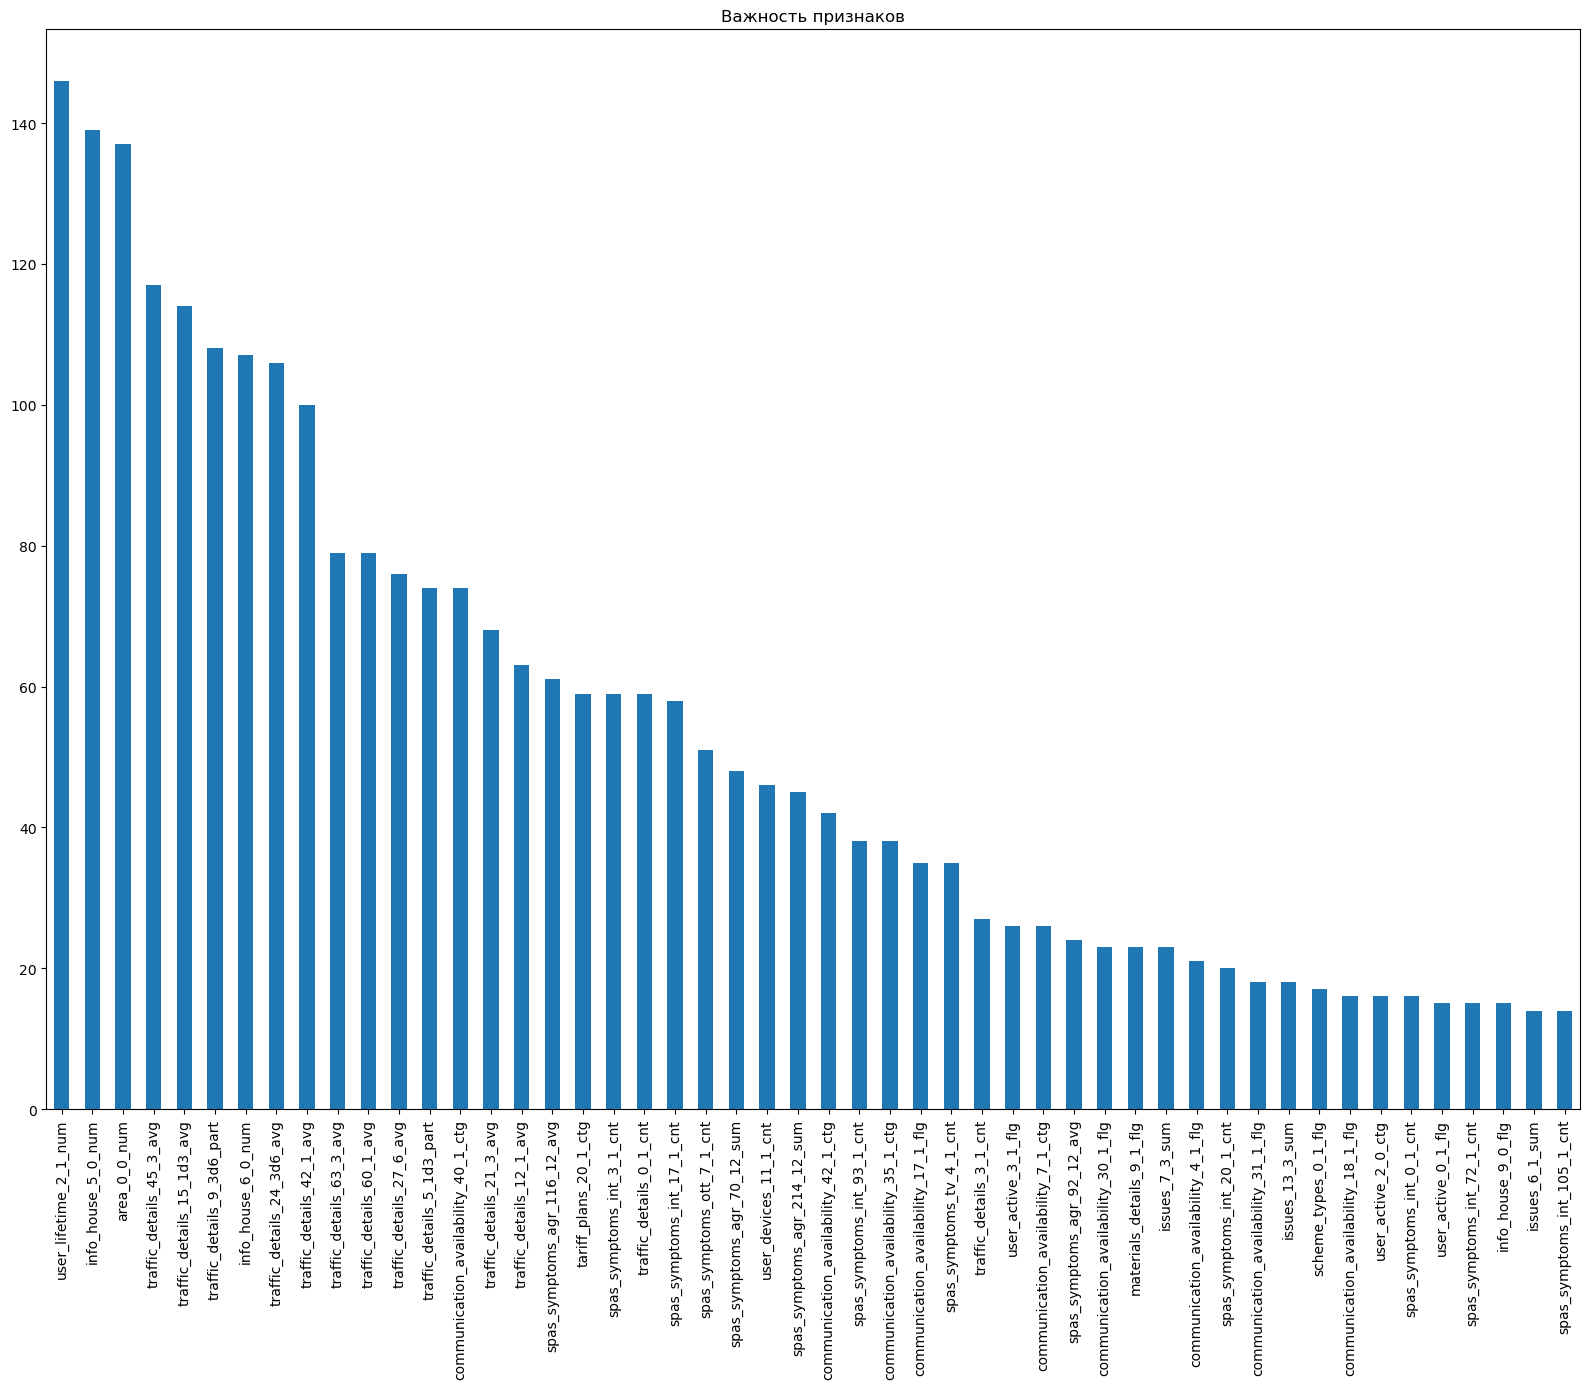

In [96]:
fig, ax = plt.subplots(figsize=(16,14))
lgbm_imp.sort_values(ascending=False).head(50).plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

Посмотрим на полученный датасет с важными признаками:

In [98]:
columns_to_read = fitures_df['feature_names'].to_list() + ['target']

dataset_for_test = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=columns_to_read)

In [99]:
dataset_for_test.head()

,user_lifetime_2_1_num,info_house_5_0_num,area_0_0_num,traffic_details_45_3_avg,traffic_details_15_1d3_avg,traffic_details_9_3d6_part,info_house_6_0_num,traffic_details_24_3d6_avg,traffic_details_42_1_avg,traffic_details_63_3_avg,...,scheme_types_0_1_flg,communication_availability_18_1_flg,user_active_2_0_ctg,spas_symptoms_int_0_1_cnt,user_active_0_1_flg,spas_symptoms_int_72_1_cnt,info_house_9_0_flg,issues_6_1_sum,spas_symptoms_int_105_1_cnt,target
0,1.047965,-0.148010,-0.389706,0.090839,-0.149562,-0.323249,0.195933,-0.525663,0.014368,-0.001010,...,0,1,1,0.349689,0,-0.092503,1,NaN,-0.162509,0
1,1.084660,-0.154880,-0.360158,-0.052862,-0.213178,0.387658,0.196460,0.089350,-0.065489,-0.008717,...,0,1,2,0.349689,0,-0.092503,0,NaN,-0.162509,0
2,0.949020,-0.159672,NaN,-0.045852,-0.558246,-0.099921,0.186659,-0.189385,-0.040976,-0.004965,...,0,1,1,0.349689,0,-0.092503,0,NaN,-0.162509,1
3,0.984405,-0.137583,-0.104079,-0.047291,4.926220,-1.230714,0.200200,0.765043,-0.057883,0.001362,...,0,1,1,0.349689,0,-0.092503,0,NaN,-0.162509,0
4,0.947710,-0.122424,1.762342,-0.002484,-0.069712,-4.287067,0.200190,-3.136473,0.089454,0.031349,...,0,1,1,-0.245287,0,-0.092503,0,NaN,-0.162509,0


In [100]:
dataset_for_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 51 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   user_lifetime_2_1_num                696827 non-null  float64
 1   info_house_5_0_num                   696471 non-null  float64
 2   area_0_0_num                         467367 non-null  float64
 3   traffic_details_45_3_avg             686189 non-null  float64
 4   traffic_details_15_1d3_avg           686189 non-null  float64
 5   traffic_details_9_3d6_part           686189 non-null  float64
 6   info_house_6_0_num                   696471 non-null  float64
 7   traffic_details_24_3d6_avg           686189 non-null  float64
 8   traffic_details_42_1_avg             686189 non-null  float64
 9   traffic_details_63_3_avg             686189 non-null  float64
 10  traffic_details_60_1_avg             686189 non-null  float64
 11  traffic_detai

In [102]:
important_futures = dataset_for_test.columns.to_list()
important_futures

['user_lifetime_2_1_num',
 'info_house_5_0_num',
 'area_0_0_num',
 'traffic_details_45_3_avg',
 'traffic_details_15_1d3_avg',
 'traffic_details_9_3d6_part',
 'info_house_6_0_num',
 'traffic_details_24_3d6_avg',
 'traffic_details_42_1_avg',
 'traffic_details_63_3_avg',
 'traffic_details_60_1_avg',
 'traffic_details_27_6_avg',
 'traffic_details_5_1d3_part',
 'communication_availability_40_1_ctg',
 'traffic_details_21_3_avg',
 'traffic_details_12_1_avg',
 'spas_symptoms_agr_116_12_avg',
 'tariff_plans_20_1_ctg',
 'spas_symptoms_int_3_1_cnt',
 'traffic_details_0_1_cnt',
 'spas_symptoms_int_17_1_cnt',
 'spas_symptoms_ott_7_1_cnt',
 'spas_symptoms_agr_70_12_sum',
 'user_devices_11_1_cnt',
 'spas_symptoms_agr_214_12_sum',
 'communication_availability_42_1_ctg',
 'spas_symptoms_int_93_1_cnt',
 'communication_availability_35_1_ctg',
 'communication_availability_17_1_flg',
 'spas_symptoms_tv_4_1_cnt',
 'traffic_details_3_1_cnt',
 'user_active_3_1_flg',
 'communication_availability_7_1_ctg',
 'sp

## Предсказание модели с новыми признаками

In [ ]:
features_fin = dataset_for_test.drop(['target'], axis=1)
target_fin = dataset_for_test['target']

In [ ]:
features_downsampled_fin, target_downsampled_fin = downsample(features_fin, target_fin, 0.01)

In [ ]:
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(features_downsampled_fin, target_downsampled_fin)

Матрицы ошибок:

In [ ]:
lgbm_predicted = model_lgbm.predict(features_downsampled_fin)

In [ ]:
cm = confusion_matrix(target_downsampled_fin, lgbm_predicted, labels=model_lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
disp.plot()

plt.show()

In [ ]:
lgbm_predicted = model_lgbm.predict(features_fin)

In [ ]:
cm = confusion_matrix(target_fin, lgbm_predicted, labels=model_lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
disp.plot()

plt.show()